# Display a beautiful graph to visualize pass completion

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen

While the passes are being calculated, we use a set of data from another match to create a script.

In [3]:
# Get stats from StatsBomb Open Data
parser = Sbopen()
df, related, freeze, tactics = parser.event(7478)
df.head()

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,foul_committed_penalty,foul_won_penalty,foul_committed_card_id,foul_committed_card_name,foul_committed_offensive,substitution_replacement_id,substitution_replacement_name,ball_recovery_offensive,bad_behaviour_card_id,bad_behaviour_card_name
0,b2192d6b-2205-43e1-8eb7-725eb875d223,1,1,00:00:00,0,0,1,0.000,7478,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fbb65556-08d5-426c-aaed-68df8e93aeac,2,1,00:00:00,0,0,1,0.000,7478,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6f8fda01-616a-42d0-a752-447e56e2b36e,3,1,00:00:00,0,0,1,0.000,7478,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3004ce16-ba43-4731-b637-d2ea5ffa10c8,4,1,00:00:00,0,0,1,0.000,7478,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31efd6a5-7e19-4e35-bbad-3d2dbe6cd54b,5,1,00:00:00.522000,0,0,2,2.181,7478,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
team1, team2 = df.team_name.unique()
mask_team1 = (df.type_name == 'Pass') & (df.team_name == team1)
df_pass = df.loc[mask_team1, ['x', 'y', 'end_x', 'end_y', 'outcome_name']]
df_pass.head()

,x,y,end_x,end_y,outcome_name
20,11.0,80.0,29.0,68.0,NaN
22,29.0,67.0,58.0,80.0,Out
28,56.0,68.0,75.0,77.0,NaN
37,95.0,80.0,110.0,56.0,NaN
40,109.0,56.0,106.0,54.0,Incomplete


In [5]:
df_pass.outcome_name.unique()

array([nan, 'Out', 'Incomplete', 'Unknown', 'Pass Offside'], dtype=object)

In [6]:
mask_complete = df_pass.outcome_name.isnull()

df_complete_pass = df_pass[mask_complete]
df_incomplete_pass = df_pass[~mask_complete]


### Plotting

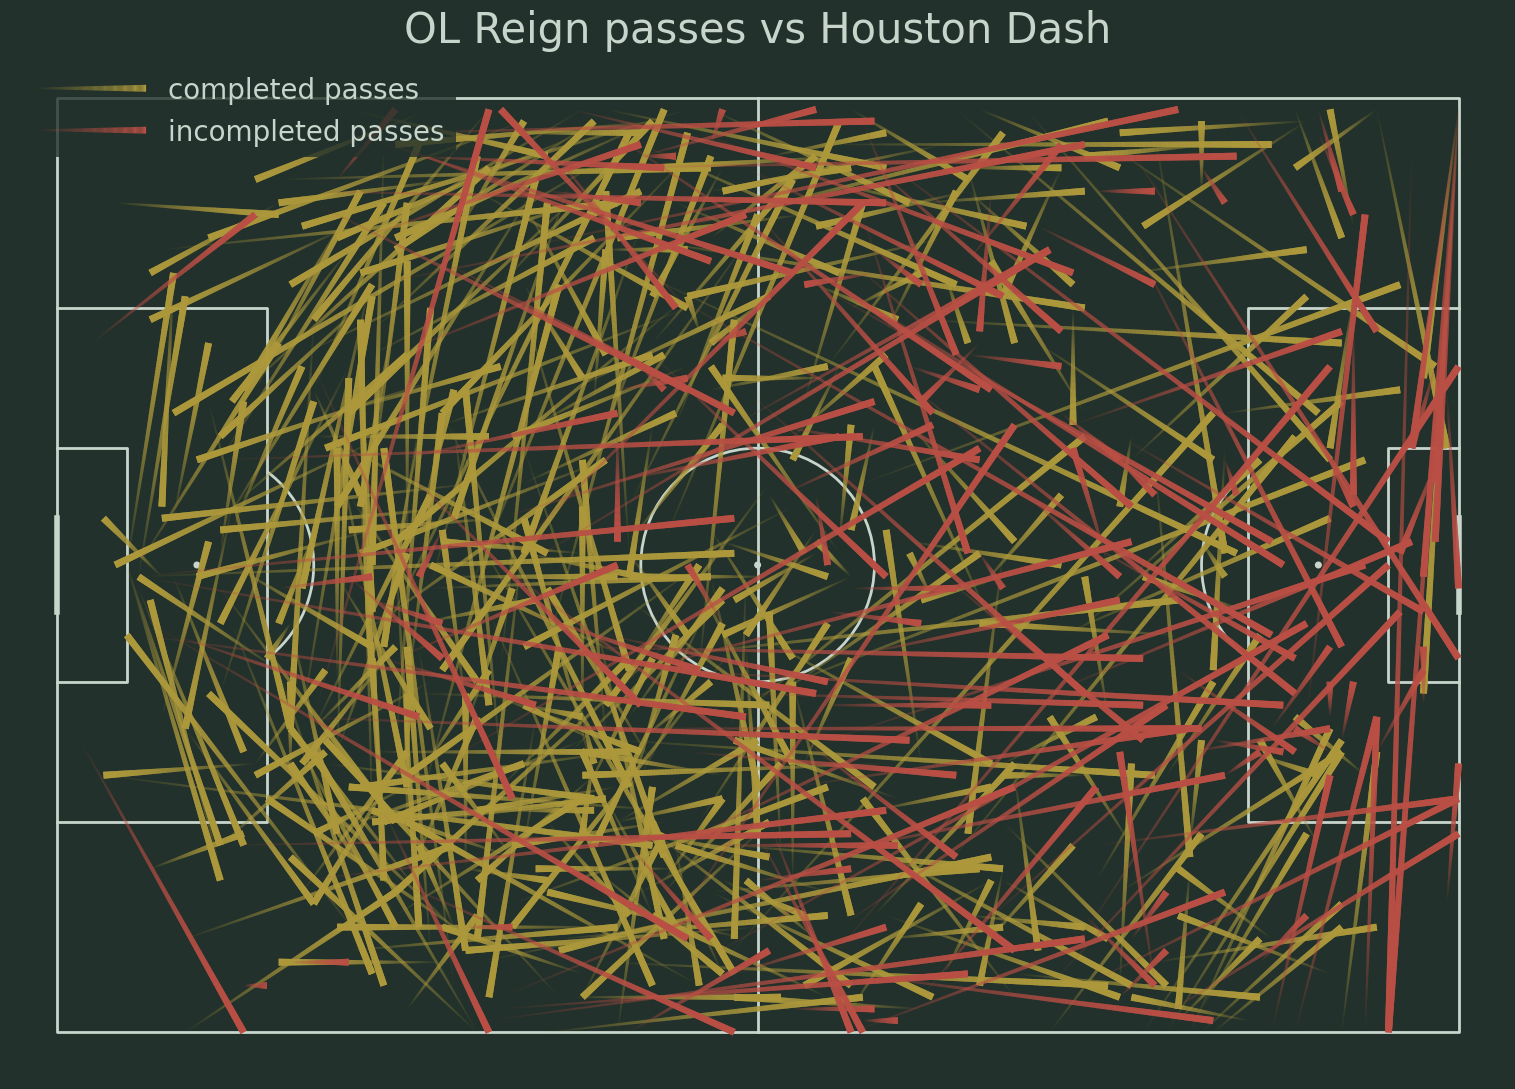

In [7]:
rcParams['text.color'] = '#c7d5cc'  # set the default text color

# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')

fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Plot the completed passes
lc1 = pitch.lines(
    xstart = df_complete_pass.x, 
    ystart = df_complete_pass.y,
    xend = df_complete_pass.end_x, 
    yend = df_complete_pass.end_y,
    lw=5, transparent=True, comet=True, 
    label='completed passes',
    color='#ad993c', ax=ax)

# Plot the other passes
lc2 = pitch.lines(
    xstart = df_incomplete_pass.x, 
    ystart = df_incomplete_pass.y,
    xend = df_incomplete_pass.end_x, 
    yend = df_incomplete_pass.end_y,
    lw=5, transparent=True, comet=True, 
    label='incompleted passes',
    color='#ba4f45', ax=ax)

# Plot the legend
ax.legend(facecolor='#22312b', edgecolor='None', 
          fontsize=20, loc='upper left', handlelength=4)

# Set the title
ax_title = ax.set_title(f'{team1} passes vs {team2}', fontsize=30)

# Another one to see the relationship

In [8]:
import pandas as pd

In [9]:
events, related, freeze, players = parser.event(15946)
TEAM = 'Barcelona'
OPPONENT = 'versus Alavés (A), 2018/19 La Liga'

In [10]:
events.loc[events.tactics_formation.notnull(), 'tactics_id'] = events.loc[
    events.tactics_formation.notnull(), 'id']
events[['tactics_id', 'tactics_formation']] = events.groupby('team_name')[[
    'tactics_id', 'tactics_formation']].ffill()

In [11]:
formation_dict = {1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB', 7: 'RWB',
                  8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM', 12: 'RM', 13: 'RCM',
                  14: 'CM', 15: 'LCM', 16: 'LM', 17: 'RW', 18: 'RAM', 19: 'CAM',
                  20: 'LAM', 21: 'LW', 22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'}
players['position_abbreviation'] = players.position_id.map(formation_dict)

In [12]:
sub = events.loc[events.type_name == 'Substitution',
                 ['tactics_id', 'player_id', 'substitution_replacement_id',
                  'substitution_replacement_name']]
players_sub = players.merge(sub.rename({'tactics_id': 'id'}, axis='columns'),
                            on=['id', 'player_id'], how='inner', validate='1:1')
players_sub = (players_sub[['id', 'substitution_replacement_id', 'position_abbreviation']]
               .rename({'substitution_replacement_id': 'player_id'}, axis='columns'))
players = pd.concat([players, players_sub])
players.rename({'id': 'tactics_id'}, axis='columns', inplace=True)
players = players[['tactics_id', 'player_id', 'position_abbreviation']]

In [13]:
players.head()

,tactics_id,player_id,position_abbreviation
0,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,20055.0,GK
1,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,6374.0,RB
2,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,5213.0,RCB
3,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,5492.0,LCB
4,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,5211.0,LB


In [14]:
# add on the position the player was playing in the formation to the events dataframe
events = events.merge(players, on=['tactics_id', 'player_id'], how='left', validate='m:1')
# add on the position the receipient was playing in the formation to the events dataframe
events = events.merge(players.rename({'player_id': 'pass_recipient_id'},
                                     axis='columns'), on=['tactics_id', 'pass_recipient_id'],
                      how='left', validate='m:1', suffixes=['', '_receipt'])

In [15]:
events.groupby('team_name').tactics_formation.unique()

team_name
Barcelona           [442, 433]
Deportivo Alavés    [451, 442]
Name: tactics_formation, dtype: object

In [16]:
FORMATION = '433'
pass_cols = ['id', 'position_abbreviation', 'position_abbreviation_receipt']
passes_formation = events.loc[(events.team_name == TEAM) & (events.type_name == 'Pass') &
                              (events.tactics_formation == FORMATION) &
                              (events.position_abbreviation_receipt.notnull()), pass_cols].copy()
location_cols = ['position_abbreviation', 'x', 'y']
location_formation = events.loc[(events.team_name == TEAM) &
                                (events.type_name.isin(['Pass', 'Ball Receipt'])) &
                                (events.tactics_formation == FORMATION), location_cols].copy()

# average locations
average_locs_and_count = (location_formation.groupby('position_abbreviation')
                          .agg({'x': ['mean'], 'y': ['mean', 'count']}))
average_locs_and_count.columns = ['x', 'y', 'count']

# calculate the number of passes between each position (using min/ max so we get passes both ways)
passes_formation['pos_max'] = (passes_formation[['position_abbreviation',
                                                'position_abbreviation_receipt']]
                               .max(axis='columns'))
passes_formation['pos_min'] = (passes_formation[['position_abbreviation',
                                                'position_abbreviation_receipt']]
                               .min(axis='columns'))
passes_between = passes_formation.groupby(['pos_min', 'pos_max']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

# add on the location of each player so we have the start and end positions of the lines
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_min', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='pos_max', right_index=True,
                                      suffixes=['', '_end'])

In [17]:
display(average_locs_and_count.head())
display(passes_between.head())

,x,y,count
position_abbreviation,,,
CDM,62.774038,41.722115,104
GK,8.808333,45.162500,24
LB,71.711864,13.522034,118
LCB,43.354237,23.574576,59
LCM,74.356881,29.707339,109


,pos_min,pos_max,pass_count,x,y,count,x_end,y_end,count_end
0,CDM,GK,3,62.774038,41.722115,104,8.808333,45.162500,24
1,CDM,LB,14,62.774038,41.722115,104,71.711864,13.522034,118
10,GK,LB,4,8.808333,45.162500,24,71.711864,13.522034,118
2,CDM,LCB,8,62.774038,41.722115,104,43.354237,23.574576,59
11,GK,LCB,4,8.808333,45.162500,24,43.354237,23.574576,59


calculate line width

In [18]:
MAX_LINE_WIDTH = 18
MAX_MARKER_SIZE = 3000
passes_between['width'] = (passes_between.pass_count / passes_between.pass_count.max() *
                           MAX_LINE_WIDTH)
average_locs_and_count['marker_size'] = (average_locs_and_count['count']
                                         / average_locs_and_count['count'].max() * MAX_MARKER_SIZE)

In [19]:
display(average_locs_and_count.head())
display(passes_between.head())

,x,y,count,marker_size
position_abbreviation,,,,
CDM,62.774038,41.722115,104,2644.067797
GK,8.808333,45.162500,24,610.169492
LB,71.711864,13.522034,118,3000.000000
LCB,43.354237,23.574576,59,1500.000000
LCM,74.356881,29.707339,109,2771.186441


,pos_min,pos_max,pass_count,x,y,count,x_end,y_end,count_end,width
0,CDM,GK,3,62.774038,41.722115,104,8.808333,45.162500,24,1.636364
1,CDM,LB,14,62.774038,41.722115,104,71.711864,13.522034,118,7.636364
10,GK,LB,4,8.808333,45.162500,24,71.711864,13.522034,118,2.181818
2,CDM,LCB,8,62.774038,41.722115,104,43.354237,23.574576,59,4.363636
11,GK,LCB,4,8.808333,45.162500,24,43.354237,23.574576,59,2.181818


add transparency

In [20]:
import numpy as np
from matplotlib.colors import to_rgba

In [21]:
MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

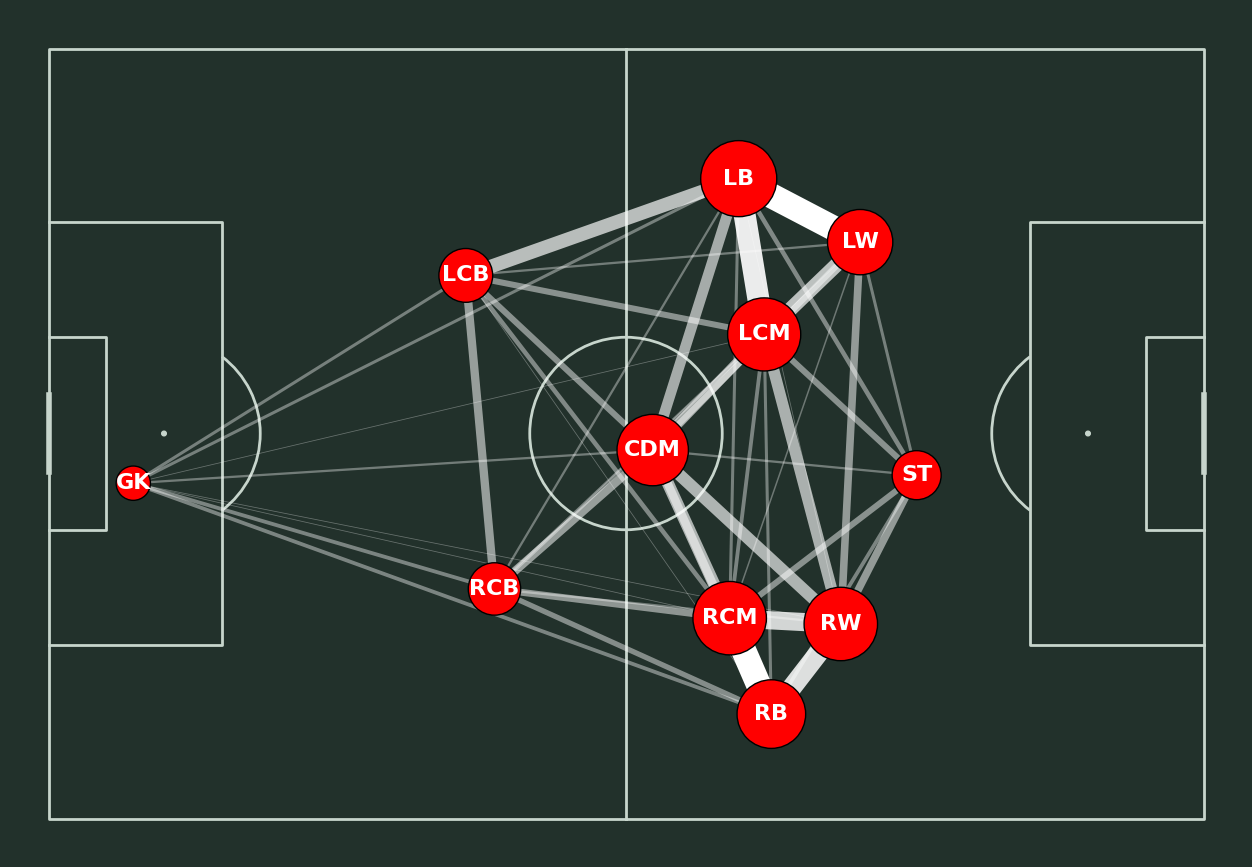

In [22]:
pitch = Pitch(pitch_type='statsbomb', 
              pitch_color='#22312b', line_color='#c7d5cc')

fig, ax = pitch.draw(figsize=(16, 11), 
                     constrained_layout=True, tight_layout=False)

fig.set_facecolor("#22312b")
pass_lines = pitch.lines(
    passes_between.x, 
    passes_between.y,
    passes_between.x_end, 
    passes_between.y_end, 
    lw=passes_between.width,
    color=color, zorder=1, ax=ax)

pass_nodes = pitch.scatter(
    average_locs_and_count.x, 
    average_locs_and_count.y,
    s=average_locs_and_count.marker_size,
    color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)

for index, row in average_locs_and_count.iterrows():
    pitch.annotate(
        row.name,
        xy=(row.x, row.y), c='white', 
        va='center', ha='center', 
        size=16, weight='bold', ax=ax)